This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [11]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import aesara
import aesara.tensor as at
import pymc as pm

import cobra
import os
os.getcwd()

from scipy import stats

from sklearn.model_selection import train_test_split

In [12]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve

In [3]:
Teusink_ant ='data/interim/Antimony/flatTeusink.ant' 
data_file = "data/interim/generated_data/flatTeusink/flatTeusink_0.5.csv"

data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()
scaledE = r.getScaledElasticityMatrix()

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
flux = ['v_' + i for i in r.getReactionIds()]

In [5]:
N_SPLITS=6
splits = np.linspace(0,1, N_SPLITS+1)[1:]

# Leaving out enzyme data

In [6]:
crossSections=[]

for i in np.random.randint(1000, size=N_SPLITS): 
    kept, omitted = train_test_split(enzymes, test_size=0.33, random_state=i)
    holey_data = pd.concat([data[internal], data[flux], data[kept], data[external]], axis=1)
    crossSections.append(holey_data)


In [ ]:
BIOMD64_0 = BMCA.BMCA(Teusink_ant, crossSections[0])
BIOMD64_1 = BMCA.BMCA(Teusink_ant, crossSections[1])
BIOMD64_2 = BMCA.BMCA(Teusink_ant, crossSections[2])
BIOMD64_3 = BMCA.BMCA(Teusink_ant, crossSections[3])
BIOMD64_4 = BMCA.BMCA(Teusink_ant, crossSections[4])
BIOMD64_5 = BMCA.BMCA(Teusink_ant, crossSections[5])

## Running ADVI

In [73]:
def calculate_e_hat(BMCA_obj, v_hat_obs, x_terms, y_terms): 
    one_n = np.ones([len(BMCA_obj.v_star),len(BMCA_obj.en)])
    product = v_hat_obs * (one_n + x_terms + y_terms)

    clip_product = aesara.tensor.clip(product, 1E-6,10)

    return aesara.tensor.reciprocal(clip_product)

In [74]:
def run_BayesInf(BMCA_obj):
    enzymes = ['e_' + i for i in r.getReactionIds()]
        
    known_e_inds = []
    omitted_e_inds = []
    for i, e in enumerate(enzymes):
        if e in holey_data.columns:
            known_e_inds.append(i)
        else: 
            omitted_e_inds.append(i)
    e_inds = np.hstack([known_e_inds, omitted_e_inds]).argsort()

    with pm.Model() as pymc_model:

        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        #Protein Expression Priors
        e_measured = pm.Normal('chi_measured', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_unmeasured = pm.Normal('chi_unmeasured', mu=0, sigma=10, shape=(len(omitted_e_inds), len(BMCA_obj.xn)))

        e_t = at.concatenate([e_measured, e_unmeasured], axis=0)[e_inds, :]
        pm.Deterministic('e_t', e_t)

        # e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_t = pm.Normal('chi_t', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        v_hat_obs = pm.Normal('v_hat_obs', mu=1, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)

        e_ss = calculate_e_hat(BMCA_obj, v_hat_obs, Ex_t@chi_t, Ey_t@y_t)
        pm.Deterministic('e_ss', e_ss)

        e_clip = e_ss[known_e_inds, :]
        e_hat = pm.Normal('e_hat', mu=e_clip, sigma=0.1, observed=BMCA_obj.en.values.T)

        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


In [75]:
trace_0 = run_BayesInf(BIOMD64_0)

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log



In [ ]:
trace_1 = run_BayesInf(BIOMD64_1)
trace_2 = run_BayesInf(BIOMD64_2)
trace_3 = run_BayesInf(BIOMD64_3)
trace_4 = run_BayesInf(BIOMD64_4)
trace_5 = run_BayesInf(BIOMD64_5)


### Plotting ADVI results

In [16]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

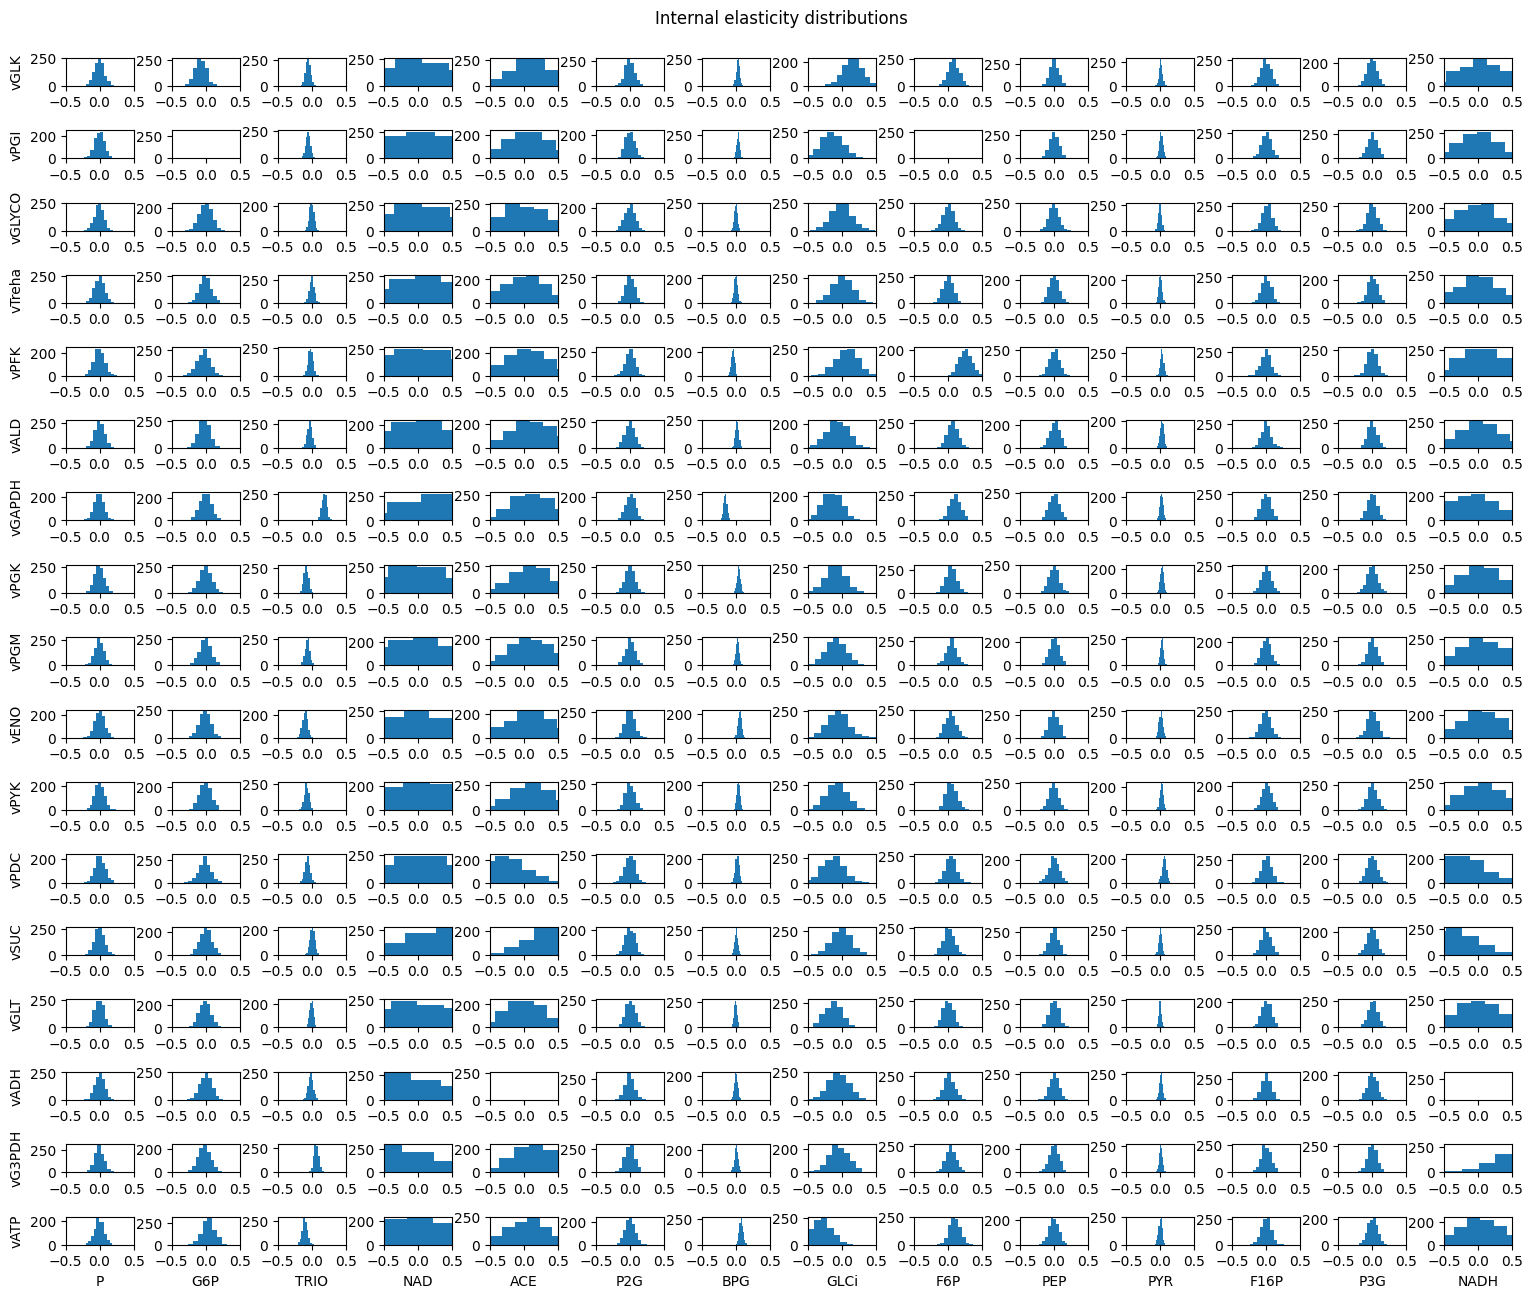

In [17]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

all distributions are unimodal so we estimate that the peak of the distribution is the median

In [18]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [19]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,0.0,-0.068345,-0.055958,0.000000,0.096417,0.000000,0.028042,0.156443,0.080929,0.0,0.000000,0.000000,0.0,0.044202
vPGI,0.0,1.102194,-0.049581,0.000000,0.065863,0.000000,0.035912,-0.150921,-0.845128,0.0,0.013201,0.000000,0.0,0.000000
vGLYCO,0.0,0.000000,0.000000,-0.034102,-0.011959,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.014023,0.0,0.000000
vTreha,0.0,0.000000,0.000000,0.046624,0.016448,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-0.011602
vPFK,0.0,-0.031296,-0.015522,0.012209,0.065383,0.000000,-0.047970,0.078640,0.253324,0.0,0.024725,0.000000,0.0,0.024117
vALD,0.0,-0.018075,-0.031032,0.000000,0.119805,0.000000,0.017718,-0.059707,0.065165,0.0,0.026135,0.000000,0.0,0.029695
vGAPDH,0.0,0.000000,0.186920,0.455831,0.117668,0.012027,-0.153849,-0.145785,0.104472,0.0,0.020143,0.000000,0.0,-0.091344
vPGK,0.0,0.000000,-0.081722,-0.038928,0.118988,0.000000,0.041815,-0.099413,0.044061,0.0,0.021624,0.000000,0.0,0.044312
vPGM,0.0,0.000000,-0.061464,-0.031935,0.101547,0.000000,0.025938,-0.092985,0.052819,0.0,0.026099,0.000000,0.0,0.051538
vENO,0.0,0.000000,-0.096994,-0.034235,0.101904,0.000000,0.055857,-0.055123,0.040076,0.0,0.000000,0.000000,0.0,0.055384


In [20]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

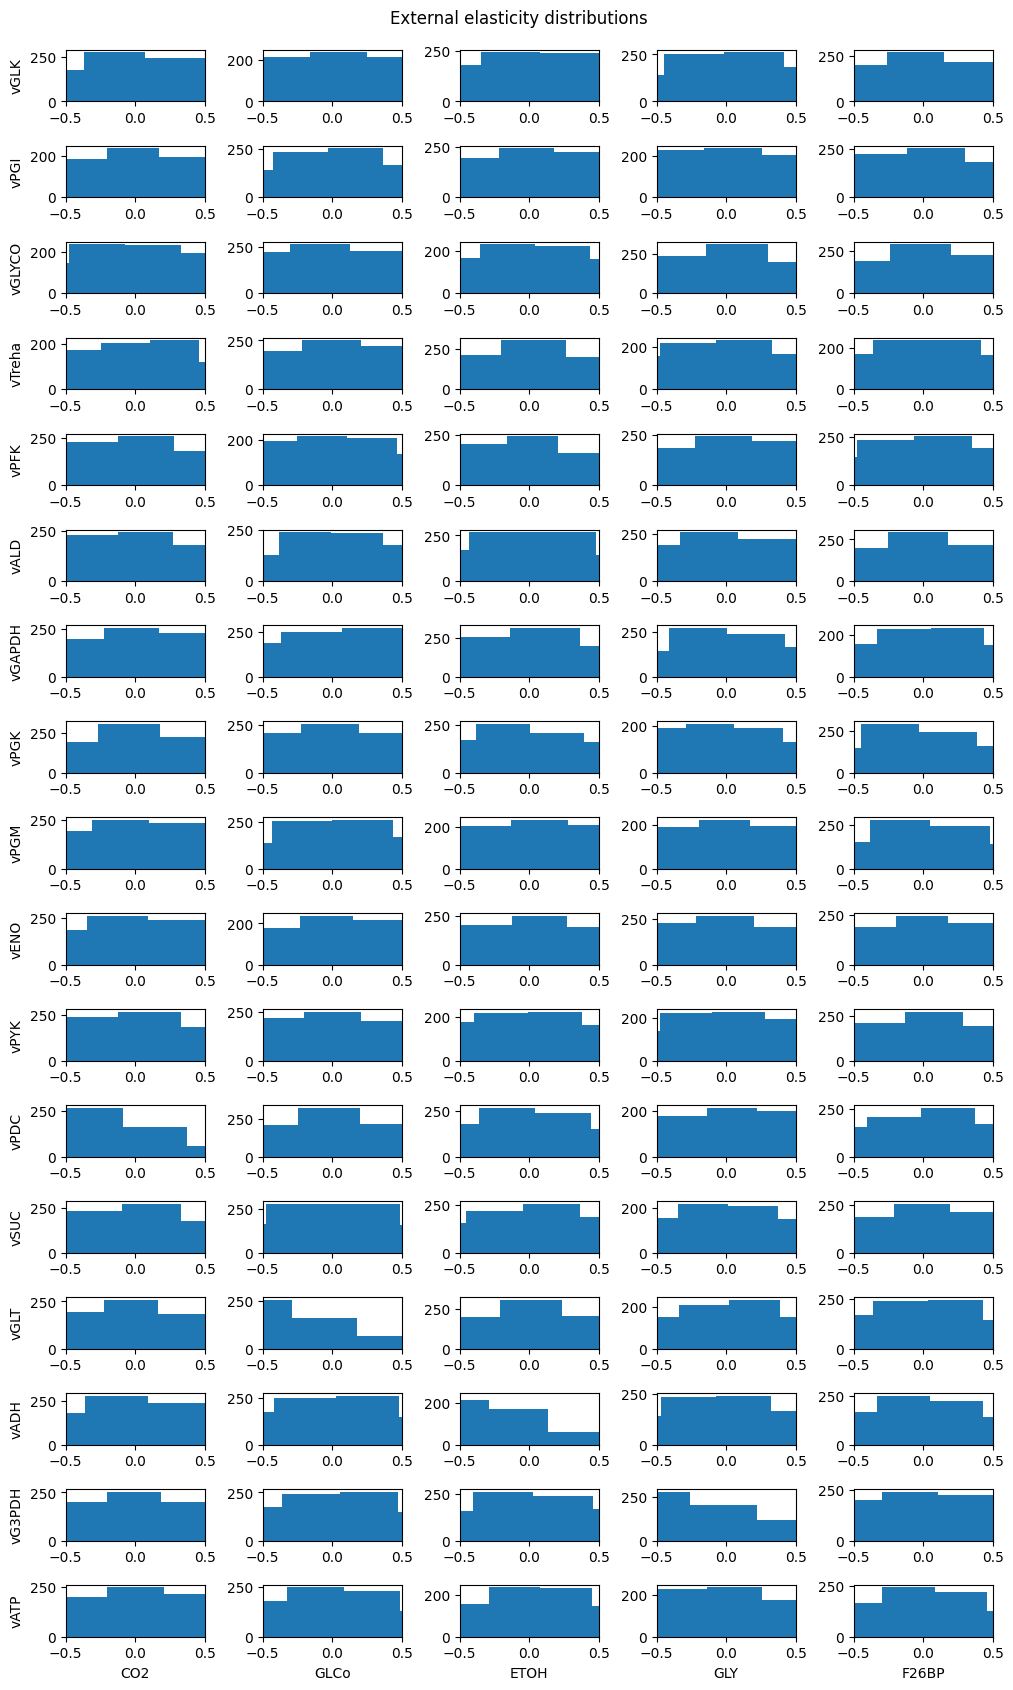

In [21]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [22]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [23]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,-0.023290,0.000000,0.023174,0.025227,0.026959
vPGI,-0.032948,0.036233,0.029155,0.023752,0.000000
vGLYCO,0.000000,-0.052943,0.020802,0.049427,0.035664
vTreha,0.040749,0.016745,-0.012375,-0.034746,0.019437
vPFK,-0.027709,-0.029886,-0.045653,0.058763,0.011620
vALD,0.000000,0.027731,0.000000,-0.045832,0.000000
vGAPDH,0.000000,0.000000,0.034103,0.000000,0.030004
vPGK,0.000000,0.012077,-0.023052,-0.034979,-0.061757
vPGM,-0.017295,0.041384,0.017599,0.000000,0.000000
vENO,0.000000,0.044641,0.010452,-0.053015,0.060983


In [24]:
enzymes = [i for i in data.columns if 'e_' in i]

In [25]:
a = data[enzymes].apply(lambda row: row[row != 1].index, axis=1)
pt_enz = [i[0] for i in a[1:]]

a = data[data[enzymes] != 1].values.flatten()
pt_lvls = a[~np.isnan(a)]

# zip pt_enz and pt_lvls together and then assign them as the column names
enzPtLvls = [x +'|'+ str(y) for x, y in zip(pt_enz, pt_lvls)]

C:\Users\user\AppData\Local\Temp\ipykernel_8300\374656274.py:2: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.



In [26]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = enzPtLvls
rel_real_values

,e_vGLK|0.9,e_vGLK|1.1,e_vPGI|0.9,e_vPGI|1.1,e_vGLYCO|0.9,e_vGLYCO|1.1,e_vTreha|0.9,e_vTreha|1.1,e_vPFK|0.9,e_vPFK|1.1,e_vALD|0.9,e_vALD|1.1,e_vGAPDH|0.9,e_vGAPDH|1.1,e_vPGK|0.9,e_vPGK|1.1,e_vPGM|0.9,e_vPGM|1.1,e_vENO|0.9,e_vENO|1.1,e_vPYK|0.9,e_vPYK|1.1,e_vPDC|0.9,e_vPDC|1.1,e_vSUC|0.9,e_vSUC|1.1,e_vGLT|0.9,e_vGLT|1.1,e_vADH|0.9,e_vADH|1.1,e_vG3PDH|0.9,e_vG3PDH|1.1,e_vATP|0.9,e_vATP|1.1,e_vGLK|0.887,e_vGLK|1.113,e_vPGI|0.887,e_vPGI|1.113,e_vGLYCO|0.887,e_vGLYCO|1.113,e_vTreha|0.887,e_vTreha|1.113,e_vPFK|0.887,e_vPFK|1.113,e_vALD|0.887,e_vALD|1.113,e_vGAPDH|0.887,e_vGAPDH|1.113,e_vPGK|0.887,e_vPGK|1.113,e_vPGM|0.887,e_vPGM|1.113,e_vENO|0.887,e_vENO|1.113,e_vPYK|0.887,e_vPYK|1.113,e_vPDC|0.887,e_vPDC|1.113,e_vSUC|0.887,e_vSUC|1.113,e_vGLT|0.887,e_vGLT|1.113,e_vADH|0.887,e_vADH|1.113,e_vG3PDH|0.887,e_vG3PDH|1.113,e_vATP|0.887,e_vATP|1.113,e_vGLK|0.873,e_vGLK|1.127,e_vPGI|0.873,e_vPGI|1.127,e_vGLYCO|0.873,e_vGLYCO|1.127,e_vTreha|0.873,e_vTreha|1.127,e_vPFK|0.873,e_vPFK|1.127,e_vALD|0.873,e_vALD|1.127,e_vGAPDH|0.873,e_vGAPDH|1.127,e_vPGK|0.873,e_vPGK|1.127,e_vPGM|0.873,e_vPGM|1.127,e_vENO|0.873,e_vENO|1.127,e_vPYK|0.873,e_vPYK|1.127,e_vPDC|0.873,e_vPDC|1.127,e_vSUC|0.873,e_vSUC|1.127,e_vGLT|0.873,e_vGLT|1.127,e_vADH|0.873,e_vADH|1.127,e_vG3PDH|0.873,e_vG3PDH|1.127,e_vATP|0.873,e_vATP|1.127,e_vGLK|0.856,e_vGLK|1.144,e_vPGI|0.856,e_vPGI|1.144,e_vGLYCO|0.856,e_vGLYCO|1.144,e_vTreha|0.856,e_vTreha|1.144,e_vPFK|0.856,e_vPFK|1.144,e_vALD|0.856,e_vALD|1.144,e_vGAPDH|0.856,e_vGAPDH|1.144,e_vPGK|0.856,e_vPGK|1.144,e_vPGM|0.856,e_vPGM|1.144,e_vENO|0.856,e_vENO|1.144,e_vPYK|0.856,e_vPYK|1.144,e_vPDC|0.856,e_vPDC|1.144,e_vSUC|0.856,e_vSUC|1.144,e_vGLT|0.856,e_vGLT|1.144,e_vADH|0.856,e_vADH|1.144,e_vG3PDH|0.856,e_vG3PDH|1.144,e_vATP|0.856,e_vATP|1.144,e_vGLK|0.838,e_vGLK|1.162,e_vPGI|0.838,e_vPGI|1.162,e_vGLYCO|0.838,e_vGLYCO|1.162,e_vTreha|0.838,e_vTreha|1.162,e_vPFK|0.838,e_vPFK|1.162,e_vALD|0.838,e_vALD|1.162,e_vGAPDH|0.838,e_vGAPDH|1.162,e_vPGK|0.838,e_vPGK|1.162,e_vPGM|0.838,e_vPGM|1.162,e_vENO|0.838,e_vENO|1.162,e_vPYK|0.838,e_vPYK|1.162,e_vPDC|0.838,e_vPDC|1.162,e_vSUC|0.838,e_vSUC|1.162,e_vGLT|0.838,e_vGLT|1.162,e_vADH|0.838,e_vADH|1.162,e_vG3PDH|0.838,e_vG3PDH|1.162,e_vATP|0.838,e_vATP|1.162,e_vGLK|0.817,e_vGLK|1.183,e_vPGI|0.817,e_vPGI|1.183,e_vGLYCO|0.817,e_vGLYCO|1.183,e_vTreha|0.817,e_vTreha|1.183,e_vPFK|0.817,e_vPFK|1.183,e_vALD|0.817,e_vALD|1.183,e_vGAPDH|0.817,e_vGAPDH|1.183,e_vPGK|0.817,e_vPGK|1.183,e_vPGM|0.817,e_vPGM|1.183,e_vENO|0.817,e_vENO|1.183,e_vPYK|0.817,e_vPYK|1.183,e_vPDC|0.817,e_vPDC|1.183,e_vSUC|0.817,e_vSUC|1.183,e_vGLT|0.817,e_vGLT|1.183,e_vADH|0.817,e_vADH|1.183,e_vG3PDH|0.817,e_vG3PDH|1.183,e_vATP|0.817,e_vATP|1.183,e_vGLK|0.793,e_vGLK|1.207,e_vPGI|0.793,e_vPGI|1.207,e_vGLYCO|0.793,e_vGLYCO|1.207,e_vTreha|0.793,e_vTreha|1.207,e_vPFK|0.793,e_vPFK|1.207,e_vALD|0.793,e_vALD|1.207,e_vGAPDH|0.793,e_vGAPDH|1.207,e_vPGK|0.793,e_vPGK|1.207,e_vPGM|0.793,e_vPGM|1.207,e_vENO|0.793,e_vENO|1.207,e_vPYK|0.793,e_vPYK|1.207,e_vPDC|0.793,e_vPDC|1.207,e_vSUC|0.793,e_vSUC|1.207,e_vGLT|0.793,e_vGLT|1.207,e_vADH|0.793,e_vADH|1.207,e_vG3PDH|0.793,e_vG3PDH|1.207,e_vATP|0.793,e_vATP|1.207,e_vGLK|0.766,e_vGLK|1.234,e_vPGI|0.766,e_vPGI|1.234,e_vGLYCO|0.766,e_vGLYCO|1.234,e_vTreha|0.766,e_vTreha|1.234,e_vPFK|0.766,e_vPFK|1.234,e_vALD|0.766,e_vALD|1.234,e_vGAPDH|0.766,e_vGAPDH|1.234,e_vPGK|0.766,e_vPGK|1.234,e_vPGM|0.766,e_vPGM|1.234,e_vENO|0.766,e_vENO|1.234,e_vPYK|0.766,e_vPYK|1.234,e_vPDC|0.766,e_vPDC|1.234,e_vSUC|0.766,e_vSUC|1.234,e_vGLT|0.766,e_vGLT|1.234,e_vADH|0.766,e_vADH|1.234,e_vG3PDH|0.766,e_vG3PDH|1.234,e_vATP|0.766,e_vATP|1.234,e_vGLK|0.736,e_vGLK|1.264,e_vPGI|0.736,e_vPGI|1.264,e_vGLYCO|0.736,e_vGLYCO|1.264,e_vTreha|0.736,e_vTreha|1.264,e_vPFK|0.736,e_vPFK|1.264,e_vALD|0.736,e_vALD|1.264,e_vGAPDH|0.736,e_vGAPDH|1.264,e_vPGK|0.736,e_vPGK|1.264,e_vPGM|0.736,e_vPGM|1.264,e_vENO|0.736,e_vENO|1.264,e_vPYK|0.736,e_vPYK|1.264,e_vPDC|0.736,e_vPDC|1.264,e_vSUC|0.736,e_vSUC|1.264,e_vGLT|0.736,e_vGLT|1.264,e_vADH|0.736,e_vADH|1.264,e

Text(-9, 4, 'r = 0.358')

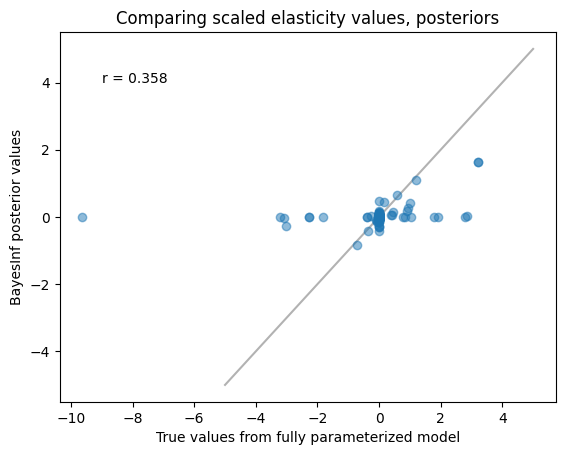

In [27]:
Ex_values = r.getScaledElasticityMatrix()

plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [ ]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [ ]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

In [ ]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


In [ ]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vADH'].rank(), visFCC.loc['vADH'].rank(), postFCC.loc['vADH'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vADH')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vGLK'].rank(), visFCC.loc['vGLK'].rank(), postFCC.loc['vGLK'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings,vGLK')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

In [ ]:
FCCrankings = pd.concat([gtFCC.loc['vPGI'].rank(), visFCC.loc['vPGI'].rank(), postFCC.loc['vPGI'].rank()], axis=1)
FCCrankings.columns=['gt', 'visE', 'postE']

fig = plt.figure()

plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficient rankings, vPGI')
plt.xlabel('ordinal values from fully parameterized model')
plt.ylabel('ordinal values from linlog approximations')

plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
plt.text(13,0,'p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))

plt.legend()

## Pairwise comparison of FCC values

In [ ]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme].sort_index()):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

In [ ]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Distribution of FCC Sp. correlation coefficients

In [ ]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


In [ ]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()


# Perturbing enzymes, leaving out flux values 

In [ ]:
kept, omitted = train_test_split(internal, test_size=0.33, random_state=42)

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
holey_data = pd.concat([data[kept], data[flux], data[enzymes], data[external]], axis=1)
holey_data.head()

In [ ]:
known_flux_inds = []
omitted_flux_inds = []
for i, v_ in enumerate(flux):
    if v_ in holey_data.columns:
        known_flux_inds.append(i)
    else: 
        omitted_flux_inds.append(i)
flux_inds = np.hstack([known_flux_inds, omitted_flux_inds]).argsort()


## Running ADVI

In [ ]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

In [ ]:
with pymc_model:
    
    e_t = pm.Normal('e_t', mu=1, sigma=1, observed=BIOMD64.en.T)
    chi_t = pm.Normal('chi_t', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_t = pm.Normal('y_t', mu=0, sigma=10, observed=BIOMD64.yn.T)


In [ ]:
with pymc_model:
    likelihood = pm.Deterministic('vn', e_t * (np.ones((17,641)) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
    
    flux_measured = pm.Normal('flux_measured', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)
    flux_unmeasured = pm.Normal('flux_unmeasured', mu=likelihood, sigma=10, shape=(len(omitted_chi_inds), len(BIOMD64.xn)))

    v_t = at.concatenate([flux_measured, flux_unmeasured], axis=0)[flux_inds, :]
    # supposedly chi_t would be in the order listed in ss tellurium

    pm.Deterministic('v_t', v_t)

In [ ]:
v_t.shape.eval() # 14, 641

In [ ]:
likelihood.shape.eval() # 14, 641
